In [ ]:
import pandas as pd
import numpy as np
import nltk
import torch
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/steam-analysis.csv')
df.dropna(subset=['user_review'], inplace=True)

In [ ]:
title_counts = df['title'].value_counts()

title_df = pd.DataFrame({'Titolo': title_counts.index, 'Conteggio': title_counts.values})

title_df

,Titolo,Conteggio
0,Magic Duels,893
1,Tree of Savior (English Ver.),635
2,Star Trek Online,566
3,Dungeon Defenders II,554
4,Paladins®,529
5,Fishing Planet,498
6,Counter-Strike: Global Offensive,463
7,Shadowverse CCG,450
8,The Lord of the Rings Online™,439
9,H1Z1,425


from matplotlib import pyplot as plt
title_df['Conteggio'].plot(kind='hist', bins=20, title='Conteggio')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
title_df['Conteggio'].plot(kind='line', figsize=(8, 4), title='Conteggio')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
review_years_per_title = df.groupby('title')['year'].apply(lambda x: sorted(x.unique())).reset_index()

review_years_per_title.columns = ['title', 'review_years']

review_years_per_title

,title,review_years
0,Aura Kingdom,"[2014.0, 2015.0, 2016.0, 2017.0, 2018.0, nan]"
1,Champions Online,"[2011.0, 2012.0, 2013.0, 2014.0, 2015.0, 2016...."
2,Counter-Strike: Global Offensive,"[2012.0, 2013.0, 2014.0, 2015.0, 2016.0, 2017...."
3,Crush Crush,"[2016.0, 2017.0, 2018.0, nan]"
4,Digimon Masters Online,"[2016.0, 2017.0, 2018.0, nan]"
5,Dungeon Defenders II,"[2014.0, 2015.0, 2016.0, 2017.0, 2018.0, nan]"
6,Fishing Planet,"[2015.0, 2016.0, 2017.0, 2018.0, nan]"
7,GUNS UP!,"[2017.0, 2018.0, nan]"
8,Governor of Poker 3,"[2016.0, 2017.0, 2018.0, nan]"
9,H1Z1,"[2016.0, 2018.0, nan, 2017.0]"


In [ ]:
def clean(raw):
    """ Remove hyperlinks and markup """
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result)
    result = re.sub('&#x27;', "'", result)
    result = re.sub('&quot;', '"', result)
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result)
    result = re.sub('</i>', '', result)
    result = re.sub('&#62;', '', result)
    result = re.sub('<i>', ' ', result)
    result = re.sub("\n", '', result)
    return result

In [ ]:
def remove_num(texts):
   output = re.sub(r'\d+', '', texts)
   return output

In [ ]:
def deEmojify(x):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', x)

In [ ]:
def unify_whitespaces(x):
    cleaned_string = re.sub(' +', ' ', x)
    return cleaned_string

In [ ]:
def remove_symbols(x):
    cleaned_string = re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', x)
    return cleaned_string

In [ ]:
def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"',','))
    return final

In [ ]:
stop=set(stopwords.words("english"))
stemmer=PorterStemmer()
lemma=WordNetLemmatizer()

def remove_stopword(text):
   text=[word.lower() for word in text.split() if word.lower() not in stop]
   return " ".join(text)

In [ ]:
def Stemming(text):
   stem=[]
   stopword = stopwords.words('english')
   snowball_stemmer = SnowballStemmer('english')
   word_tokens = nltk.word_tokenize(text)
   stemmed_word = [snowball_stemmer.stem(word) for word in word_tokens]
   stem=' '.join(stemmed_word)
   return stem

In [ ]:
def cleaning(df,review):
    df[review] = df[review].apply(clean)
    df[review] = df[review].apply(deEmojify)
    df[review] = df[review].str.lower()
    df[review] = df[review].apply(remove_num)
    df[review] = df[review].apply(remove_symbols)
    df[review] = df[review].apply(remove_punctuation)
    df[review] = df[review].apply(remove_stopword)
    df[review] = df[review].apply(unify_whitespaces)
    df[review] = df[review].apply(Stemming)

In [ ]:
cleaning(df,'user_review')
df[['user_review']].head(20)

,user_review
0,nice graphic new map weapon model develop list...
1,would recommend get current state csgo hit roc...
2,edit tri play cs go recent dramat gotten wors ...
3,game great communiti worstif match russian may...
4,thank trulyrazor buy long time ago insist woul...
5,kind hard say like game hour gameplay addict l...
6,sinc old fan halo game find cs go nice sequel ...
7,hepimiz k kl zde counter strike oyunlar ndan b...
8,death great teacher failur counter strike glob...
9,one worst communiti game griefer cheater squea...


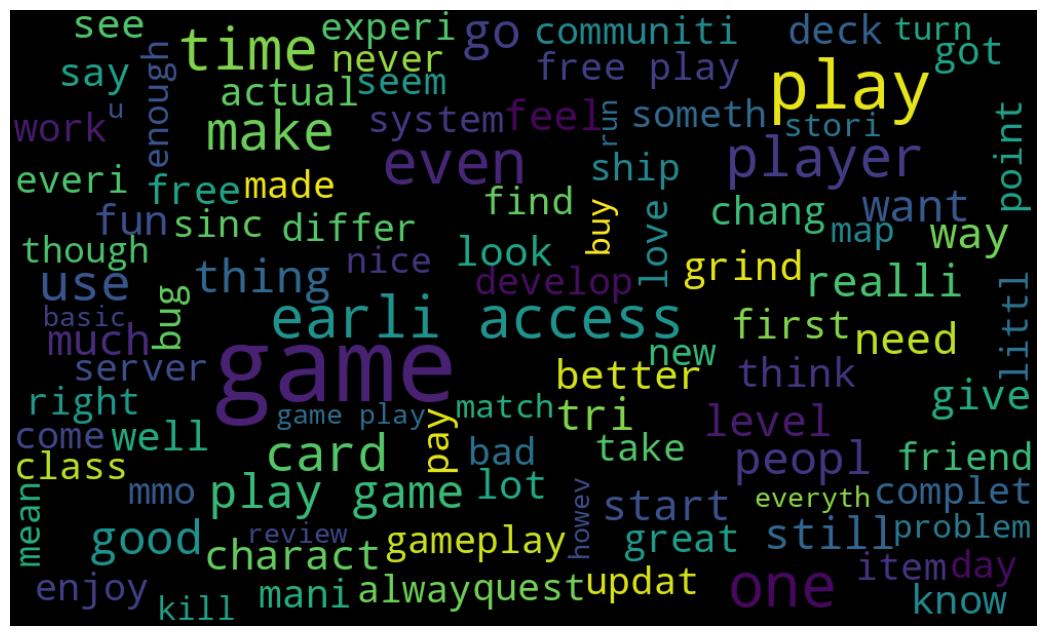

In [ ]:
txt = ' '.join(rev for rev in df['user_review'])
stop_words = set(stopwords.words('english'))
words_filtered = []
for word in txt.split():
    word = re.sub(r'[^\w\s]', '', word)
    if word.lower() not in stop_words and word != '':
        words_filtered.append(word)

words_filtered = ' '.join(words_filtered)

plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(words_filtered)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

model.load_state_dict(torch.load("/content/drive/MyDrive/bert-sa-steam/bert-sa-steam.pt"))
model.eval()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    #inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.sigmoid(logits)
    positive_class_prob = probabilities[:, 1]
    negative_class_prob = probabilities[:, 0]
    if positive_class_prob > negative_class_prob:
      predictions = 1
    else:
      predictions = 0
    return predictions


data_steam = []

for i, text in df.iterrows():
    sentiment = predict_sentiment(text['user_review'])
    data_steam.append({'name': text['title'], 'review': text['user_review'],'sentiment_analysis': sentiment})
    #print(f"Text: {text['review_text']}\nSentiment: {sentiment}\n")

data_steam = pd.DataFrame(data_steam)
data_steam.to_csv('/content/drive/MyDrive/bert-sa-steam/data_steam.csv')

In [ ]:
print(data_steam)

                                  name  \
0     Counter-Strike: Global Offensive   
1     Counter-Strike: Global Offensive   
2     Counter-Strike: Global Offensive   
3     Counter-Strike: Global Offensive   
4     Counter-Strike: Global Offensive   
...                                ...   
8040                          GUNS UP!   
8041                          GUNS UP!   
8042                          GUNS UP!   
8043                          GUNS UP!   
8044                          GUNS UP!   

                                                 review  sentiment_analysis  
0     nice graphic new map weapon model develop list...                   1  
1     would recommend get current state csgo hit roc...                   0  
2     edit tri play cs go recent dramat gotten wors ...                   0  
3     game great communiti worstif match russian may...                   0  
4     thank trulyrazor buy long time ago insist woul...                   1  
...                        

In [ ]:
data_steam = pd.read_csv('/content/drive/MyDrive/bert-sa-steam/data_steam.csv')

data_steam = data_steam.merge(df[['user_review', 'year']], left_on='review', right_on='user_review', how='left')

data_steam.drop(columns='user_review', inplace=True)

genres = pd.DataFrame({
    'Name': ['Aura Kingdom', 'Champions Online', 'Counter-Strike: Global Offensive', 'Crush Crush', 'Digimon Masters Online', 'Dungeon Defenders II', 'Fishing Planet', 'GUNS UP!', 'Governor of Poker 3', 'H1Z1', 'Magic Duels', 'Minion Masters', 'Paladins®', 'Shadowverse CCG', 'Shakes and Fidget', 'Star Trek Online', 'The Lord of the Rings Online™', 'Tree of Savior (English Ver.)', 'VEGA Conflict', 'World of Warships'],
    'genre': ['MMORPG', 'MMORPG', 'FPS', 'RP', 'MMORPG', 'TD', 'S', 'SG', 'MMO', 'BR', 'SG', 'TD', 'FPS', 'SG', 'MMORPG', 'MMORPG', 'MMORPG', 'MMORPG', 'SG', 'MMO']
})

data_steam = data_steam.merge(genres, left_on='name', right_on='Name').drop(columns='Name')

data_steam = data_steam[['name', 'genre', 'year', 'review', 'sentiment_analysis']]

data_steam


,name,genre,year,review,sentiment_analysis
0,Counter-Strike: Global Offensive,FPS,2015.0,nice graphic new map weapon model develop list...,1
1,Counter-Strike: Global Offensive,FPS,2018.0,would recommend get current state csgo hit roc...,0
2,Counter-Strike: Global Offensive,FPS,2018.0,edit tri play cs go recent dramat gotten wors ...,0
3,Counter-Strike: Global Offensive,FPS,2015.0,game great communiti worstif match russian may...,0
4,Counter-Strike: Global Offensive,FPS,2015.0,thank trulyrazor buy long time ago insist woul...,1
...,...,...,...,...,...
8226,GUNS UP!,SG,2017.0,earli access reviewgun upposit good idea addic...,1
8227,GUNS UP!,SG,2018.0,hrs review spend money would seam better cheat...,0
8228,GUNS UP!,SG,2018.0,pros fun gameplaycon micro ing transact realli...,1
8229,GUNS UP!,SG,2018.0,actuali sauci definet suggest player life new ...,0


Anno 2011

In [ ]:
data_steam_2011 = data_steam[data_steam['year'] == 2011]

summary_2011 = data_steam_2011.groupby('name')['sentiment_analysis'].value_counts().unstack(fill_value=0).reset_index()
summary_2011.columns = ['Name', 'Sentiment 0', 'Sentiment 1']

summary_2011['Percentuale gradimento'] = np.ceil(summary_2011['Sentiment 1'] / (summary_2011['Sentiment 0'] + summary_2011['Sentiment 1']) * 100).astype(int)

genres = data_steam_2011[['name', 'genre']].drop_duplicates(subset='name').set_index('name')
summary_2011 = summary_2011.merge(genres, left_on='Name', right_index=True, how='left')

summary_2011 = summary_2011[['Name', 'genre', 'Sentiment 0', 'Sentiment 1', 'Percentuale gradimento']]
summary_2011.columns = ['Name', 'Genere', 'Sentiment 0', 'Sentiment 1', 'Percentuale gradimento']

summary_2011

,Name,Genere,Sentiment 0,Sentiment 1,Percentuale gradimento
0,Champions Online,MMORPG,7,50,88


ANNO 2012

In [ ]:
data_steam_2012 = data_steam[data_steam['year'] == 2012]

summary_2012 = data_steam_2012.groupby('name')['sentiment_analysis'].value_counts().unstack(fill_value=0).reset_index()
summary_2012.columns = ['Name', 'Sentiment 0', 'Sentiment 1']

summary_2012['Percentuale gradimento'] = np.ceil(summary_2012['Sentiment 1'] / (summary_2012['Sentiment 0'] + summary_2012['Sentiment 1']) * 100).astype(int)

summary_2012 = summary_2012.merge(summary_2011[['Name', 'Percentuale gradimento']], on='Name', how='left', suffixes=('', '_2011'))

summary_2012['Differenza gradimento'] = summary_2012.apply(
    lambda row: row['Percentuale gradimento'] - row['Percentuale gradimento_2011']
    if not np.isnan(row['Percentuale gradimento_2011']) else 'NR', axis=1
)

summary_2012.drop(columns=['Percentuale gradimento_2011'], inplace=True)

summary_2012 = summary_2012.sort_values(by='Percentuale gradimento', ascending=False).reset_index(drop=True)

genres = data_steam_2012[['name', 'genre']].drop_duplicates(subset='name').set_index('name')
summary_2012 = summary_2012.merge(genres, left_on='Name', right_index=True, how='left')

summary_2012 = summary_2012[['Name', 'genre', 'Sentiment 0', 'Sentiment 1', 'Percentuale gradimento', 'Differenza gradimento']]
summary_2012.columns = ['Name', 'Genere', 'Sentiment 0', 'Sentiment 1', 'Percentuale gradimento', 'Differenza gradimento']

summary_2012

,Name,Genere,Sentiment 0,Sentiment 1,Percentuale gradimento,Differenza gradimento
0,The Lord of the Rings Online™,MMORPG,1,22,96,NR
1,Star Trek Online,MMORPG,2,26,93,NR
2,Champions Online,MMORPG,2,18,90,2.0
3,Counter-Strike: Global Offensive,FPS,1,3,75,NR


<ipython-input-36-fdeef0c1e002>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(summary_2012['Name'], rotation=90)


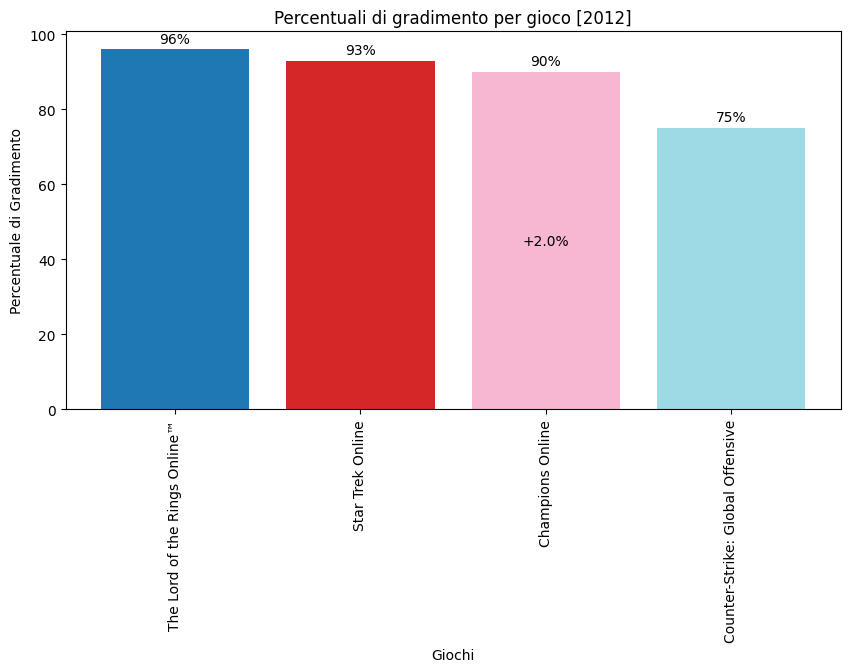

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

colors = plt.cm.tab20(np.linspace(0, 1, len(summary_2012['Name'])))

bars = ax.bar(summary_2012['Name'], summary_2012['Percentuale gradimento'], color=colors)

ax.set_xlabel('Giochi')
ax.set_ylabel('Percentuale di Gradimento')
ax.set_title('Percentuali di gradimento per gioco [2012]')

ax.set_xticklabels(summary_2012['Name'], rotation=90)

for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval:.0f}%', ha='center', va='bottom')

for i, (name, diff) in enumerate(zip(summary_2012['Name'], summary_2012['Differenza gradimento'])):
    if diff != 'NR':
        diff = float(diff)
        ax.text(bars[i].get_x() + bars[i].get_width() / 2, bars[i].get_height() / 2, f'{diff:+.1f}%', ha='center', va='center', color='black')

plt.subplots_adjust(bottom=0.25)

plt.show()

In [ ]:
summary_genre_2012 = summary_2012.groupby('Genere').agg({'Name': 'size', 'Sentiment 0': 'sum', 'Sentiment 1': 'sum'}).reset_index()

summary_genre_2012.rename(columns={'Name': 'Tot_Giochi'}, inplace=True)

summary_genre_2012['Percentuale gradimento'] = np.ceil(summary_genre_2012['Sentiment 1'] / (summary_genre_2012['Sentiment 0'] + summary_genre_2012['Sentiment 1']) * 100).astype(int)

summary_genre_2012 = summary_genre_2012.sort_values(by='Percentuale gradimento', ascending=False)

summary_genre_2012

,Genere,Tot_Giochi,Sentiment 0,Sentiment 1,Percentuale gradimento
1,MMORPG,3,5,66,93
0,FPS,1,1,3,75


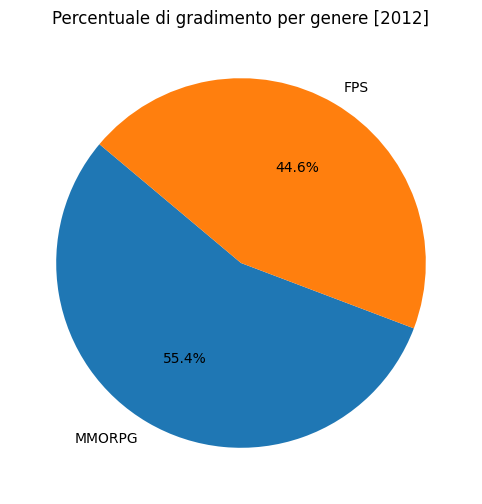

In [ ]:
plt.figure(figsize=(10, 6))
plt.pie(summary_genre_2012['Percentuale gradimento'], labels=summary_genre_2012['Genere'], autopct='%1.1f%%', startangle=140)
plt.title('Percentuale di gradimento per genere [2012]')
plt.show()

Anno 2013

In [ ]:
data_steam_2013 = data_steam[data_steam['year'] == 2013]

summary_2013 = data_steam_2013.groupby('name')['sentiment_analysis'].value_counts().unstack(fill_value=0).reset_index()
summary_2013.columns = ['Name', 'Sentiment 0', 'Sentiment 1']

summary_2013['Percentuale gradimento'] = np.ceil(summary_2013['Sentiment 1'] / (summary_2013['Sentiment 0'] + summary_2013['Sentiment 1']) * 100).astype(int)

summary_2013 = summary_2013.merge(summary_2012[['Name', 'Percentuale gradimento']], on='Name', how='left', suffixes=('', '_2012'))

summary_2013['Differenza gradimento'] = summary_2013.apply(
    lambda row: row['Percentuale gradimento'] - row['Percentuale gradimento_2012']
    if not np.isnan(row['Percentuale gradimento_2012']) else 'NR', axis=1
)

summary_2013.drop(columns=['Percentuale gradimento_2012'], inplace=True)

summary_2013 = summary_2013.sort_values(by='Percentuale gradimento', ascending=False).reset_index(drop=True)

genres = data_steam_2013[['name', 'genre']].drop_duplicates(subset='name').set_index('name')
summary_2013 = summary_2013.merge(genres, left_on='Name', right_index=True, how='left')

summary_2013 = summary_2013[['Name', 'genre', 'Sentiment 0', 'Sentiment 1', 'Percentuale gradimento', 'Differenza gradimento']]
summary_2013.columns = ['Name', 'Genere', 'Sentiment 0', 'Sentiment 1', 'Percentuale gradimento', 'Differenza gradimento']

summary_2013

,Name,Genere,Sentiment 0,Sentiment 1,Percentuale gradimento,Differenza gradimento
0,The Lord of the Rings Online™,MMORPG,1,31,97,1
1,Star Trek Online,MMORPG,5,49,91,-2
2,Counter-Strike: Global Offensive,FPS,2,18,90,15
3,Champions Online,MMORPG,6,11,65,-25


<ipython-input-56-b18811d8d0a0>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(summary_2013['Name'], rotation=90)


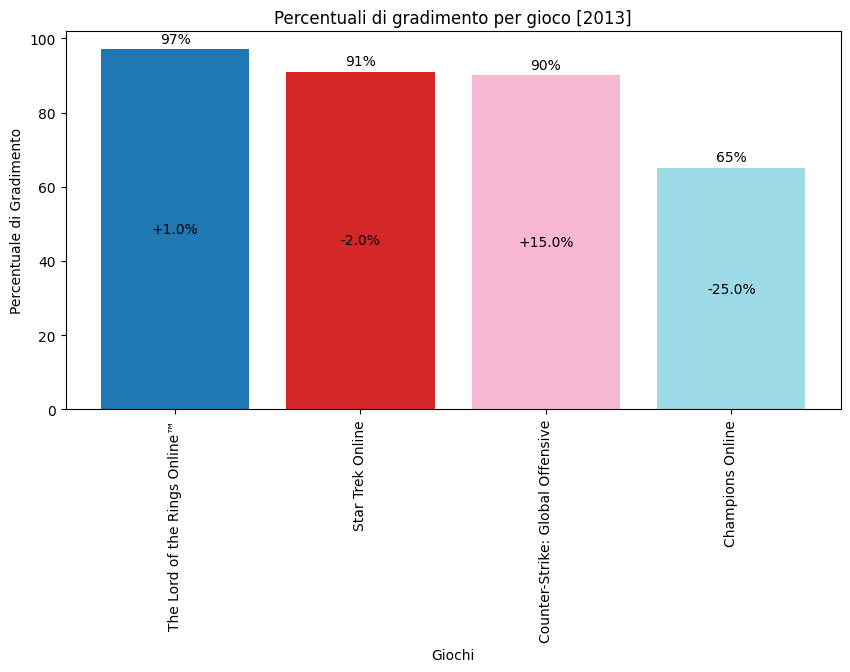

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

colors = plt.cm.tab20(np.linspace(0, 1, len(summary_2013['Name'])))

bars = ax.bar(summary_2013['Name'], summary_2013['Percentuale gradimento'], color=colors)

ax.set_xlabel('Giochi')
ax.set_ylabel('Percentuale di Gradimento')
ax.set_title('Percentuali di gradimento per gioco [2013]')

ax.set_xticklabels(summary_2013['Name'], rotation=90)

for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval:.0f}%', ha='center', va='bottom')

for i, (name, diff) in enumerate(zip(summary_2013['Name'], summary_2013['Differenza gradimento'])):
    if diff != 'NR':
        diff = float(diff)
        ax.text(bars[i].get_x() + bars[i].get_width() / 2, bars[i].get_height() / 2, f'{diff:+.1f}%', ha='center', va='center', color='black')

plt.subplots_adjust(bottom=0.25)

plt.show()

In [ ]:
summary_genre_2013 = summary_2013.groupby('Genere').agg({'Name': 'size', 'Sentiment 0': 'sum', 'Sentiment 1': 'sum'}).reset_index()

summary_genre_2013.rename(columns={'Name': 'Tot_Giochi'}, inplace=True)

summary_genre_2013['Percentuale gradimento'] = np.ceil(summary_genre_2013['Sentiment 1'] / (summary_genre_2013['Sentiment 0'] + summary_genre_2013['Sentiment 1']) * 100).astype(int)

summary_genre_2013 = summary_genre_2013.sort_values(by='Percentuale gradimento', ascending=False)

summary_genre_2013['Differenza gradimento'] = np.nan

for index, row in summary_genre_2013.iterrows():
    genre = row['Genere']
    if genre in summary_genre_2012['Genere'].values:
        percentuale_2012 = summary_genre_2012.loc[summary_genre_2012['Genere'] == genre, 'Percentuale gradimento'].iloc[0]
        differenza = row['Percentuale gradimento'] - percentuale_2012
        summary_genre_2013.at[index, 'Differenza gradimento'] = differenza
    else:
        summary_genre_2013.at[index, 'Differenza gradimento'] = 'NP'

summary_genre_2013

,Genere,Tot_Giochi,Sentiment 0,Sentiment 1,Percentuale gradimento,Differenza gradimento
0,FPS,1,2,18,90,15.0
1,MMORPG,3,12,91,89,-4.0


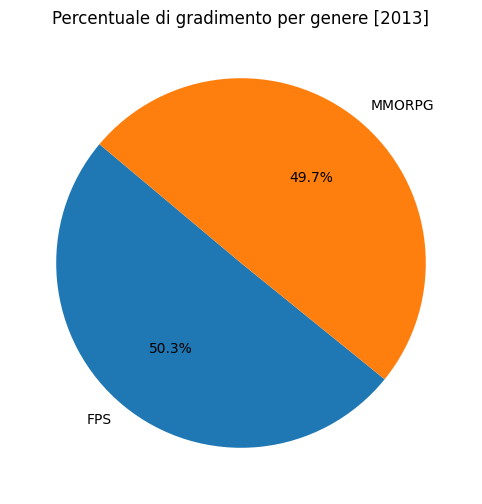

In [ ]:
plt.figure(figsize=(10, 6))
plt.pie(summary_genre_2013['Percentuale gradimento'], labels=summary_genre_2013['Genere'], autopct='%1.1f%%', startangle=140)
plt.title('Percentuale di gradimento per genere [2013]')
plt.show()

ANNO 2014

In [ ]:
data_steam_2014 = data_steam[data_steam['year'] == 2014]

summary_2014 = data_steam_2014.groupby('name')['sentiment_analysis'].value_counts().unstack(fill_value=0).reset_index()
summary_2014.columns = ['Name', 'Sentiment 0', 'Sentiment 1']

summary_2014['Percentuale gradimento'] = np.ceil(summary_2014['Sentiment 1'] / (summary_2014['Sentiment 0'] + summary_2014['Sentiment 1']) * 100).astype(int)

summary_2014 = summary_2014.merge(summary_2013[['Name', 'Percentuale gradimento']], on='Name', how='left', suffixes=('', '_2013'))

summary_2014['Differenza gradimento'] = summary_2014.apply(
    lambda row: row['Percentuale gradimento'] - row['Percentuale gradimento_2013']
    if not np.isnan(row['Percentuale gradimento_2013']) else 'NR', axis=1
)

summary_2014.drop(columns=['Percentuale gradimento_2013'], inplace=True)

summary_2014 = summary_2014.sort_values(by='Percentuale gradimento', ascending=False).reset_index(drop=True)

genres = data_steam_2014[['name', 'genre']].drop_duplicates(subset='name').set_index('name')
summary_2014 = summary_2014.merge(genres, left_on='Name', right_index=True, how='left')

summary_2014 = summary_2014[['Name', 'genre', 'Sentiment 0', 'Sentiment 1', 'Percentuale gradimento', 'Differenza gradimento']]
summary_2014.columns = ['Name', 'Genere', 'Sentiment 0', 'Sentiment 1', 'Percentuale gradimento', 'Differenza gradimento']

summary_2014

,Name,Genere,Sentiment 0,Sentiment 1,Percentuale gradimento,Differenza gradimento
0,The Lord of the Rings Online™,MMORPG,15,90,86,-11.0
1,Aura Kingdom,MMORPG,16,67,81,NR
2,Dungeon Defenders II,TD,6,20,77,NR
3,Star Trek Online,MMORPG,34,104,76,-15.0
4,Counter-Strike: Global Offensive,FPS,24,70,75,-15.0
5,Champions Online,MMORPG,29,53,65,0.0


<ipython-input-61-1ef323e1ca10>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(summary_2014['Name'], rotation=90)


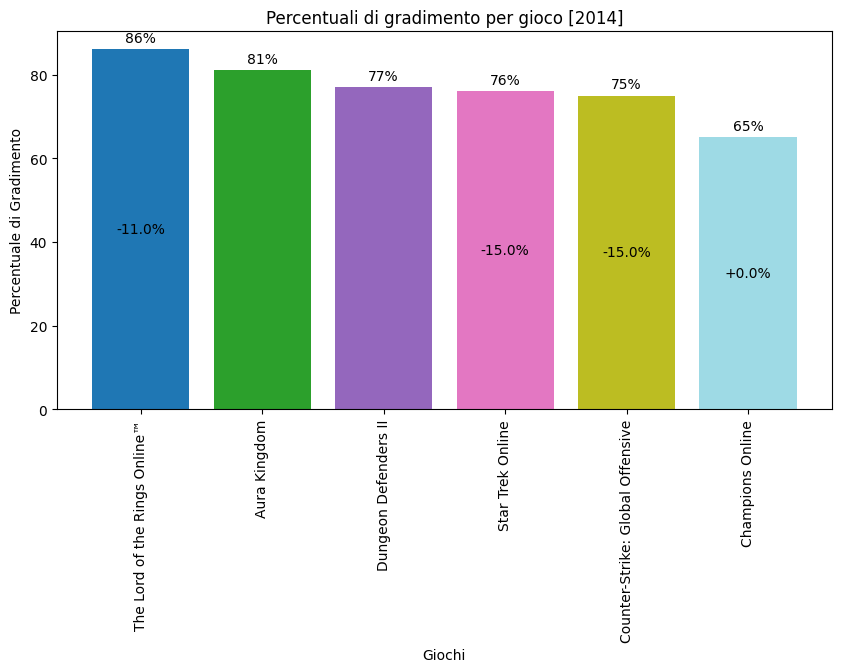

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

colors = plt.cm.tab20(np.linspace(0, 1, len(summary_2014['Name'])))

bars = ax.bar(summary_2014['Name'], summary_2014['Percentuale gradimento'], color=colors)

ax.set_xlabel('Giochi')
ax.set_ylabel('Percentuale di Gradimento')
ax.set_title('Percentuali di gradimento per gioco [2014]')

ax.set_xticklabels(summary_2014['Name'], rotation=90)

for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval:.0f}%', ha='center', va='bottom')

for i, (name, diff) in enumerate(zip(summary_2014['Name'], summary_2014['Differenza gradimento'])):
    if diff != 'NR':
        diff = float(diff)
        ax.text(bars[i].get_x() + bars[i].get_width() / 2, bars[i].get_height() / 2, f'{diff:+.1f}%', ha='center', va='center', color='black')

plt.subplots_adjust(bottom=0.25)

plt.show()

In [ ]:
summary_genre_2014 = summary_2014.groupby('Genere').agg({'Name': 'size', 'Sentiment 0': 'sum', 'Sentiment 1': 'sum'}).reset_index()

summary_genre_2014.rename(columns={'Name': 'Tot_Giochi'}, inplace=True)

summary_genre_2014['Percentuale gradimento'] = np.ceil(summary_genre_2014['Sentiment 1'] / (summary_genre_2014['Sentiment 0'] + summary_genre_2014['Sentiment 1']) * 100).astype(int)

summary_genre_2014 = summary_genre_2014.sort_values(by='Percentuale gradimento', ascending=False)

summary_genre_2014['Differenza gradimento'] = np.nan

for index, row in summary_genre_2014.iterrows():
    genre = row['Genere']
    if genre in summary_genre_2013['Genere'].values:
        percentuale_2013 = summary_genre_2013.loc[summary_genre_2013['Genere'] == genre, 'Percentuale gradimento'].iloc[0]
        differenza = row['Percentuale gradimento'] - percentuale_2013
        summary_genre_2014.at[index, 'Differenza gradimento'] = differenza
    else:
        summary_genre_2014.at[index, 'Differenza gradimento'] = 'NP'

summary_genre_2014

,Genere,Tot_Giochi,Sentiment 0,Sentiment 1,Percentuale gradimento,Differenza gradimento
1,MMORPG,4,94,314,77,-12.0
2,TD,1,6,20,77,NP
0,FPS,1,24,70,75,-15


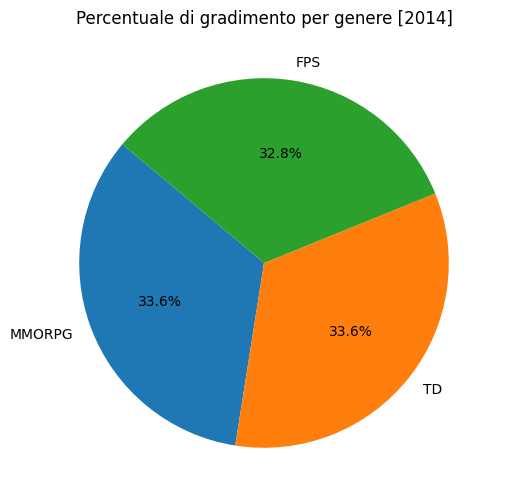

In [ ]:
plt.figure(figsize=(10, 6))
plt.pie(summary_genre_2014['Percentuale gradimento'], labels=summary_genre_2014['Genere'], autopct='%1.1f%%', startangle=140)
plt.title('Percentuale di gradimento per genere [2014]')
plt.show()

ANNO 2015

In [ ]:
data_steam_2015 = data_steam[data_steam['year'] == 2015]

summary_2015 = data_steam_2015.groupby('name')['sentiment_analysis'].value_counts().unstack(fill_value=0).reset_index()
summary_2015.columns = ['Name', 'Sentiment 0', 'Sentiment 1']

summary_2015['Percentuale gradimento'] = np.ceil(summary_2015['Sentiment 1'] / (summary_2015['Sentiment 0'] + summary_2015['Sentiment 1']) * 100).astype(int)

summary_2015 = summary_2015.merge(summary_2014[['Name', 'Percentuale gradimento']], on='Name', how='left', suffixes=('', '_2014'))

summary_2015['Differenza gradimento'] = summary_2015.apply(
    lambda row: row['Percentuale gradimento'] - row['Percentuale gradimento_2014']
    if not np.isnan(row['Percentuale gradimento_2014']) else 'NR', axis=1
)

summary_2015.drop(columns=['Percentuale gradimento_2014'], inplace=True)

summary_2015 = summary_2015.sort_values(by='Percentuale gradimento', ascending=False).reset_index(drop=True)

genres = data_steam_2015[['name', 'genre']].drop_duplicates(subset='name').set_index('name')
summary_2015 = summary_2015.merge(genres, left_on='Name', right_index=True, how='left')

summary_2015 = summary_2015[['Name', 'genre', 'Sentiment 0', 'Sentiment 1', 'Percentuale gradimento', 'Differenza gradimento']]
summary_2015.columns = ['Name', 'Genere', 'Sentiment 0', 'Sentiment 1', 'Percentuale gradimento', 'Differenza gradimento']

summary_2015

,Name,Genere,Sentiment 0,Sentiment 1,Percentuale gradimento,Differenza gradimento
0,Crush Crush,RP,0,2,100,NR
1,H1Z1,BR,0,4,100,NR
2,Paladins®,FPS,0,4,100,NR
3,Fishing Planet,S,54,232,82,NR
4,The Lord of the Rings Online™,MMORPG,16,66,81,-5.0
5,Dungeon Defenders II,TD,37,138,79,2.0
6,Counter-Strike: Global Offensive,FPS,39,77,67,-8.0
7,Champions Online,MMORPG,31,55,64,-1.0
8,Aura Kingdom,MMORPG,31,49,62,-19.0
9,VEGA Conflict,SG,7,11,62,NR


<ipython-input-68-a556b7ca6ad4>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(summary_2015['Name'], rotation=90)


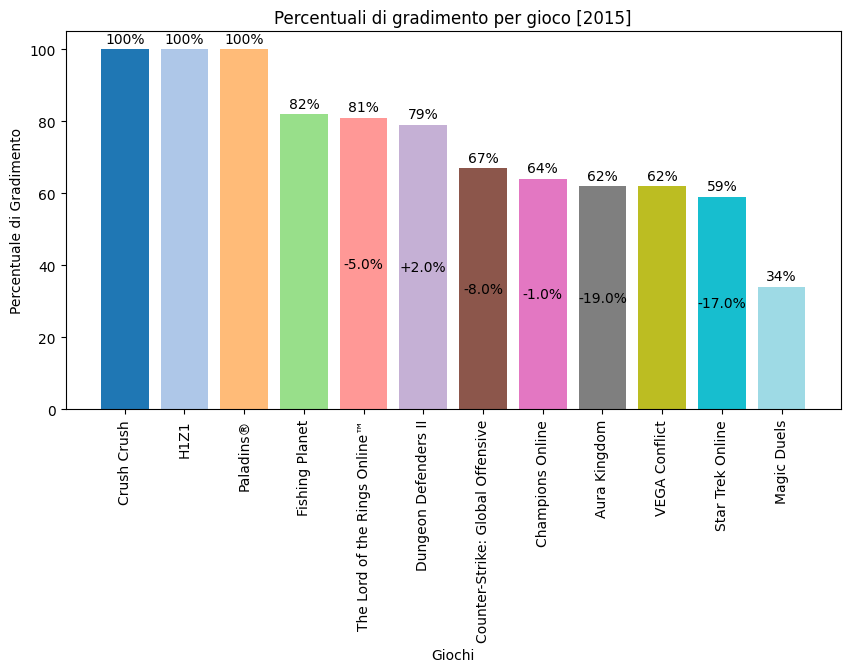

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

colors = plt.cm.tab20(np.linspace(0, 1, len(summary_2015['Name'])))

bars = ax.bar(summary_2015['Name'], summary_2015['Percentuale gradimento'], color=colors)

ax.set_xlabel('Giochi')
ax.set_ylabel('Percentuale di Gradimento')
ax.set_title('Percentuali di gradimento per gioco [2015]')

ax.set_xticklabels(summary_2015['Name'], rotation=90)

for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval:.0f}%', ha='center', va='bottom')

for i, (name, diff) in enumerate(zip(summary_2015['Name'], summary_2015['Differenza gradimento'])):
    if diff != 'NR':
        diff = float(diff)
        ax.text(bars[i].get_x() + bars[i].get_width() / 2, bars[i].get_height() / 2, f'{diff:+.1f}%', ha='center', va='center', color='black')

plt.subplots_adjust(bottom=0.25)

plt.show()

In [ ]:
summary_genre_2015 = summary_2015.groupby('Genere').agg({'Name': 'size', 'Sentiment 0': 'sum', 'Sentiment 1': 'sum'}).reset_index()

summary_genre_2015.rename(columns={'Name': 'Tot_Giochi'}, inplace=True)

summary_genre_2015['Percentuale gradimento'] = np.ceil(summary_genre_2015['Sentiment 1'] / (summary_genre_2015['Sentiment 0'] + summary_genre_2015['Sentiment 1']) * 100).astype(int)

summary_genre_2015 = summary_genre_2015.sort_values(by='Percentuale gradimento', ascending=False)

summary_genre_2015['Differenza gradimento'] = np.nan

for index, row in summary_genre_2015.iterrows():
    genre = row['Genere']
    if genre in summary_genre_2014['Genere'].values:
        percentuale_2014 = summary_genre_2014.loc[summary_genre_2014['Genere'] == genre, 'Percentuale gradimento'].iloc[0]
        differenza = row['Percentuale gradimento'] - percentuale_2014
        summary_genre_2015.at[index, 'Differenza gradimento'] = differenza
    else:
        summary_genre_2015.at[index, 'Differenza gradimento'] = 'NP'

summary_genre_2015

,Genere,Tot_Giochi,Sentiment 0,Sentiment 1,Percentuale gradimento,Differenza gradimento
0,BR,1,0,4,100,NP
3,RP,1,0,2,100,NP
4,S,1,54,232,82,NP
6,TD,1,37,138,79,2
1,FPS,2,39,81,68,-7
2,MMORPG,4,129,243,66,-11
5,SG,2,250,131,35,NP


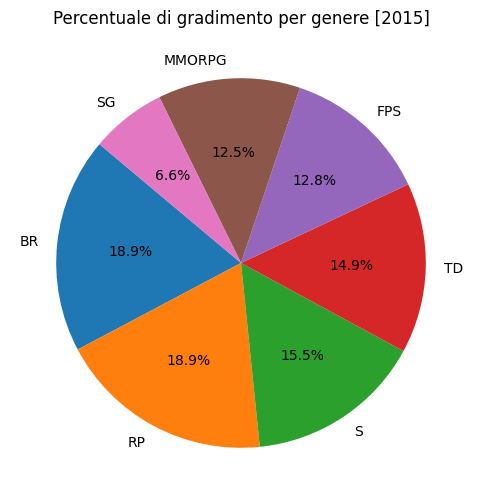

In [ ]:
plt.figure(figsize=(10, 6))
plt.pie(summary_genre_2015['Percentuale gradimento'], labels=summary_genre_2015['Genere'], autopct='%1.1f%%', startangle=140)
plt.title('Percentuale di gradimento per genere [2015]')
plt.show()

ANNO 2016

In [ ]:
data_steam_2016 = data_steam[data_steam['year'] == 2016]

summary_2016 = data_steam_2016.groupby('name')['sentiment_analysis'].value_counts().unstack(fill_value=0).reset_index()
summary_2016.columns = ['Name', 'Sentiment 0', 'Sentiment 1']

summary_2016['Percentuale gradimento'] = np.ceil(summary_2016['Sentiment 1'] / (summary_2016['Sentiment 0'] + summary_2016['Sentiment 1']) * 100).astype(int)

summary_2016 = summary_2016.merge(summary_2015[['Name', 'Percentuale gradimento']], on='Name', how='left', suffixes=('', '_2015'))

summary_2016['Differenza gradimento'] = summary_2016.apply(
    lambda row: row['Percentuale gradimento'] - row['Percentuale gradimento_2015']
    if not np.isnan(row['Percentuale gradimento_2015']) else 'NR', axis=1
)

summary_2016.drop(columns=['Percentuale gradimento_2015'], inplace=True)

summary_2016 = summary_2016.sort_values(by='Percentuale gradimento', ascending=False).reset_index(drop=True)

genres = data_steam_2016[['name', 'genre']].drop_duplicates(subset='name').set_index('name')
summary_2016 = summary_2016.merge(genres, left_on='Name', right_index=True, how='left')

summary_2016 = summary_2016[['Name', 'genre', 'Sentiment 0', 'Sentiment 1', 'Percentuale gradimento', 'Differenza gradimento']]
summary_2016.columns = ['Name', 'Genere', 'Sentiment 0', 'Sentiment 1', 'Percentuale gradimento', 'Differenza gradimento']

summary_2016

,Name,Genere,Sentiment 0,Sentiment 1,Percentuale gradimento,Differenza gradimento
0,The Lord of the Rings Online™,MMORPG,9,85,91,10.0
1,Shadowverse CCG,SG,12,110,91,NR
2,Shakes and Fidget,MMORPG,19,58,76,NR
3,Fishing Planet,S,21,61,75,-7.0
4,Crush Crush,RP,54,148,74,-26.0
5,Governor of Poker 3,MMO,14,35,72,NR
6,Paladins®,FPS,43,102,71,-29.0
7,Minion Masters,TD,22,53,71,NR
8,Star Trek Online,MMORPG,30,66,69,10.0
9,Champions Online,MMORPG,20,38,66,2.0


<ipython-input-79-05033bb9ba31>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(summary_2016['Name'], rotation=90)


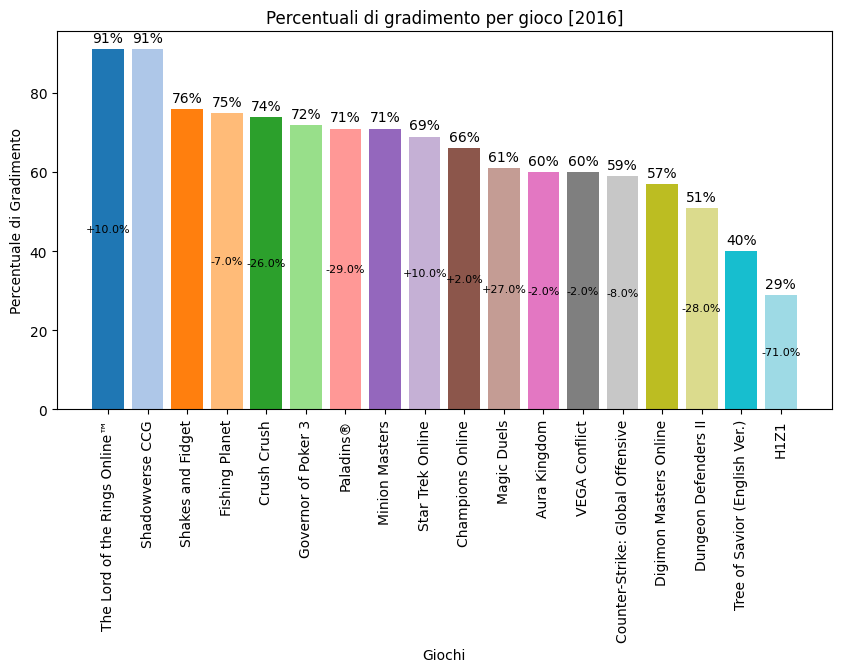

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

colors = plt.cm.tab20(np.linspace(0, 1, len(summary_2016['Name'])))

bars = ax.bar(summary_2016['Name'], summary_2016['Percentuale gradimento'], color=colors)

ax.set_xlabel('Giochi')
ax.set_ylabel('Percentuale di Gradimento')
ax.set_title('Percentuali di gradimento per gioco [2016]')

ax.set_xticklabels(summary_2016['Name'], rotation=90)

for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval:.0f}%', ha='center', va='bottom')

for i, (name, diff) in enumerate(zip(summary_2016['Name'], summary_2016['Differenza gradimento'])):
    if diff != 'NR':
        diff = float(diff)
        ax.text(bars[i].get_x() + bars[i].get_width() / 2, bars[i].get_height() / 2, f'{diff:+.1f}%', fontsize=8, ha='center', va='center', color='black')

plt.subplots_adjust(bottom=0.25)

plt.show()

In [ ]:
summary_genre_2016 = summary_2016.groupby('Genere').agg({'Name': 'size', 'Sentiment 0': 'sum', 'Sentiment 1': 'sum'}).reset_index()

summary_genre_2016.rename(columns={'Name': 'Tot_Giochi'}, inplace=True)

summary_genre_2016['Percentuale gradimento'] = np.ceil(summary_genre_2016['Sentiment 1'] / (summary_genre_2016['Sentiment 0'] + summary_genre_2016['Sentiment 1']) * 100).astype(int)

summary_genre_2016 = summary_genre_2016.sort_values(by='Percentuale gradimento', ascending=False)

summary_genre_2016['Differenza gradimento'] = np.nan

for index, row in summary_genre_2016.iterrows():
    genre = row['Genere']
    if genre in summary_genre_2015['Genere'].values:
        percentuale_2015 = summary_genre_2015.loc[summary_genre_2015['Genere'] == genre, 'Percentuale gradimento'].iloc[0]
        differenza = row['Percentuale gradimento'] - percentuale_2015
        summary_genre_2016.at[index, 'Differenza gradimento'] = differenza
    else:
        summary_genre_2016.at[index, 'Differenza gradimento'] = 'NP'

summary_genre_2016

,Genere,Tot_Giochi,Sentiment 0,Sentiment 1,Percentuale gradimento,Differenza gradimento
5,S,1,21,61,75,-7.0
4,RP,1,54,148,74,-26.0
2,MMO,1,14,35,72,NP
6,SG,3,186,374,67,32
1,FPS,2,88,165,66,-2
7,TD,2,111,143,57,-22
3,MMORPG,7,474,573,55,-11
0,BR,1,77,31,29,-71


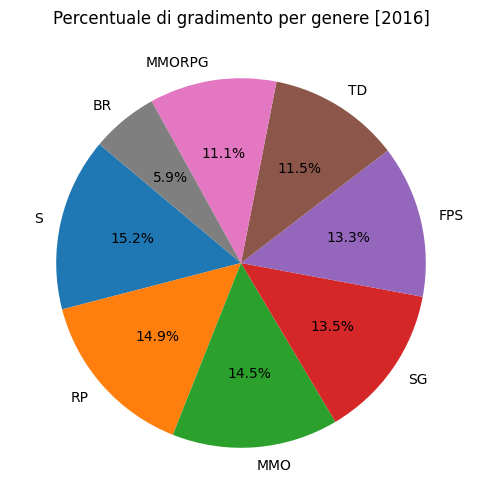

In [ ]:
plt.figure(figsize=(10, 6))
plt.pie(summary_genre_2016['Percentuale gradimento'], labels=summary_genre_2016['Genere'], autopct='%1.1f%%', startangle=140)
plt.title('Percentuale di gradimento per genere [2016]')
plt.show()

ANNO 2017

In [ ]:
data_steam_2017 = data_steam[data_steam['year'] == 2017]

summary_2017 = data_steam_2017.groupby('name')['sentiment_analysis'].value_counts().unstack(fill_value=0).reset_index()
summary_2017.columns = ['Name', 'Sentiment 0', 'Sentiment 1']

summary_2017['Percentuale gradimento'] = np.ceil(summary_2017['Sentiment 1'] / (summary_2017['Sentiment 0'] + summary_2017['Sentiment 1']) * 100).astype(int)

summary_2017 = summary_2017.merge(summary_2016[['Name', 'Percentuale gradimento']], on='Name', how='left', suffixes=('', '_2016'))

summary_2017['Differenza gradimento'] = summary_2017.apply(
    lambda row: row['Percentuale gradimento'] - row['Percentuale gradimento_2016']
    if not np.isnan(row['Percentuale gradimento_2016']) else 'NR', axis=1
)

summary_2017.drop(columns=['Percentuale gradimento_2016'], inplace=True)

summary_2017 = summary_2017.sort_values(by='Percentuale gradimento', ascending=False).reset_index(drop=True)

genres = data_steam_2017[['name', 'genre']].drop_duplicates(subset='name').set_index('name')
summary_2017 = summary_2017.merge(genres, left_on='Name', right_index=True, how='left')

summary_2017 = summary_2017[['Name', 'genre', 'Sentiment 0', 'Sentiment 1', 'Percentuale gradimento', 'Differenza gradimento']]
summary_2017.columns = ['Name', 'Genere', 'Sentiment 0', 'Sentiment 1', 'Percentuale gradimento', 'Differenza gradimento']

summary_2017

,Name,Genere,Sentiment 0,Sentiment 1,Percentuale gradimento,Differenza gradimento
0,The Lord of the Rings Online™,MMORPG,11,63,86,-5.0
1,Shadowverse CCG,SG,49,177,79,-12.0
2,Crush Crush,RP,26,72,74,0.0
3,Champions Online,MMORPG,11,25,70,4.0
4,Star Trek Online,MMORPG,25,57,70,1.0
5,Shakes and Fidget,MMORPG,11,21,66,-10.0
6,World of Warships,MMO,55,80,60,NR
7,Aura Kingdom,MMORPG,28,37,57,-3.0
8,Paladins®,FPS,126,148,55,-16.0
9,Dungeon Defenders II,TD,68,77,54,3.0


<ipython-input-83-8c0560ec2e1e>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(summary_2017['Name'], rotation=90)


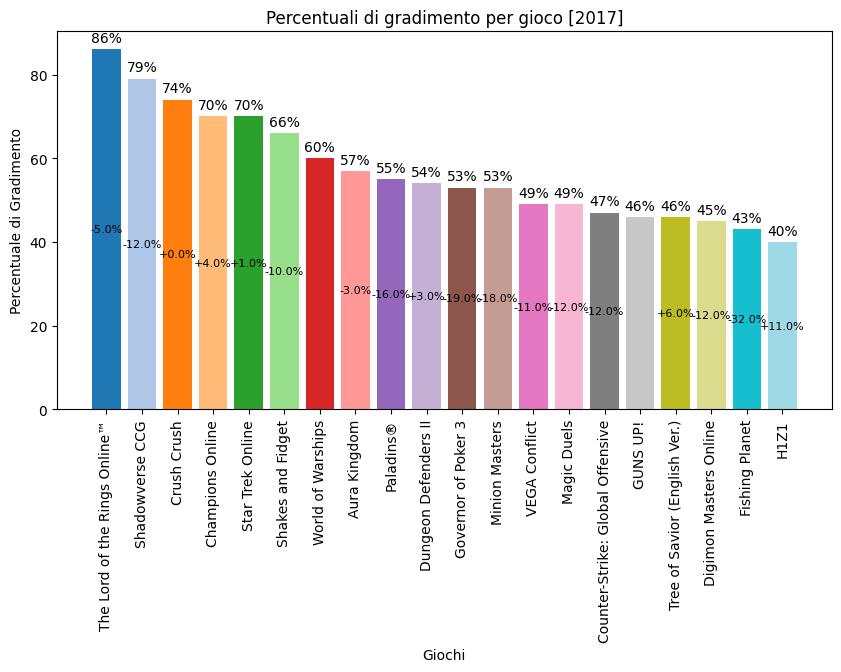

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

colors = plt.cm.tab20(np.linspace(0, 1, len(summary_2017['Name'])))

bars = ax.bar(summary_2017['Name'], summary_2017['Percentuale gradimento'], color=colors)

ax.set_xlabel('Giochi')
ax.set_ylabel('Percentuale di Gradimento')
ax.set_title('Percentuali di gradimento per gioco [2017]')

ax.set_xticklabels(summary_2017['Name'], rotation=90)

for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval:.0f}%', ha='center', va='bottom')

for i, (name, diff) in enumerate(zip(summary_2017['Name'], summary_2017['Differenza gradimento'])):
    if diff != 'NR':
        diff = float(diff)
        ax.text(bars[i].get_x() + bars[i].get_width() / 2, bars[i].get_height() / 2, f'{diff:+.1f}%', fontsize=8, ha='center', va='center', color='black')

plt.subplots_adjust(bottom=0.25)

plt.show()

In [ ]:
summary_genre_2017 = summary_2017.groupby('Genere').agg({'Name': 'size', 'Sentiment 0': 'sum', 'Sentiment 1': 'sum'}).reset_index()

summary_genre_2017.rename(columns={'Name': 'Tot_Giochi'}, inplace=True)

summary_genre_2017['Percentuale gradimento'] = np.ceil(summary_genre_2017['Sentiment 1'] / (summary_genre_2017['Sentiment 0'] + summary_genre_2017['Sentiment 1']) * 100).astype(int)

summary_genre_2017 = summary_genre_2017.sort_values(by='Percentuale gradimento', ascending=False)

summary_genre_2017['Differenza gradimento'] = np.nan

for index, row in summary_genre_2017.iterrows():
    genre = row['Genere']
    if genre in summary_genre_2016['Genere'].values:
        percentuale_2016 = summary_genre_2016.loc[summary_genre_2016['Genere'] == genre, 'Percentuale gradimento'].iloc[0]
        differenza = row['Percentuale gradimento'] - percentuale_2016
        summary_genre_2017.at[index, 'Differenza gradimento'] = differenza
    else:
        summary_genre_2017.at[index, 'Differenza gradimento'] = 'NP'

summary_genre_2017

,Genere,Tot_Giochi,Sentiment 0,Sentiment 1,Percentuale gradimento,Differenza gradimento
4,RP,1,26,72,74,0.0
6,SG,4,174,294,63,-4.0
3,MMORPG,7,211,305,60,5.0
2,MMO,2,64,90,59,-13.0
1,FPS,2,160,178,53,-13.0
7,TD,2,160,179,53,-4.0
5,S,1,58,43,43,-32.0
0,BR,1,125,81,40,11.0


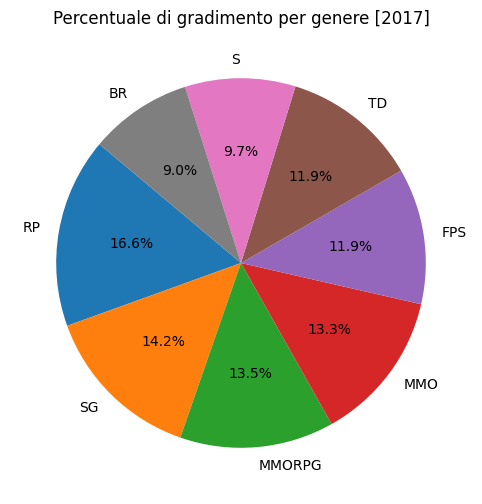

In [ ]:
plt.figure(figsize=(10, 6))
plt.pie(summary_genre_2017['Percentuale gradimento'], labels=summary_genre_2017['Genere'], autopct='%1.1f%%', startangle=140)
plt.title('Percentuale di gradimento per genere [2017]')
plt.show()

ANNO 2018

In [ ]:
data_steam_2018 = data_steam[data_steam['year'] == 2018]

summary_2018 = data_steam_2018.groupby('name')['sentiment_analysis'].value_counts().unstack(fill_value=0).reset_index()
summary_2018.columns = ['Name', 'Sentiment 0', 'Sentiment 1']

summary_2018['Percentuale gradimento'] = np.ceil(summary_2018['Sentiment 1'] / (summary_2018['Sentiment 0'] + summary_2018['Sentiment 1']) * 100).astype(int)

summary_2018 = summary_2018.merge(summary_2017[['Name', 'Percentuale gradimento']], on='Name', how='left', suffixes=('', '_2017'))

summary_2018['Differenza gradimento'] = summary_2018.apply(
    lambda row: row['Percentuale gradimento'] - row['Percentuale gradimento_2017']
    if not np.isnan(row['Percentuale gradimento_2017']) else 'NR', axis=1
)

summary_2018.drop(columns=['Percentuale gradimento_2017'], inplace=True)

summary_2018 = summary_2018.sort_values(by='Percentuale gradimento', ascending=False).reset_index(drop=True)

genres = data_steam_2018[['name', 'genre']].drop_duplicates(subset='name').set_index('name')
summary_2018 = summary_2018.merge(genres, left_on='Name', right_index=True, how='left')

summary_2018 = summary_2018[['Name', 'genre', 'Sentiment 0', 'Sentiment 1', 'Percentuale gradimento', 'Differenza gradimento']]
summary_2018.columns = ['Name', 'Genere', 'Sentiment 0', 'Sentiment 1', 'Percentuale gradimento', 'Differenza gradimento']

summary_2018

,Name,Genere,Sentiment 0,Sentiment 1,Percentuale gradimento,Differenza gradimento
0,Crush Crush,RP,7,34,83,9
1,The Lord of the Rings Online™,MMORPG,7,21,75,-11
2,Star Trek Online,MMORPG,14,36,72,2
3,Champions Online,MMORPG,8,20,72,2
4,Shadowverse CCG,SG,34,70,68,-11
5,World of Warships,MMO,76,145,66,6
6,Shakes and Fidget,MMORPG,11,20,65,-1
7,Digimon Masters Online,MMORPG,17,28,63,18
8,Tree of Savior (English Ver.),MMORPG,11,17,61,15
9,Fishing Planet,S,15,20,58,15


<ipython-input-127-36d0f20eec0e>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(summary_2018['Name'], rotation=90)


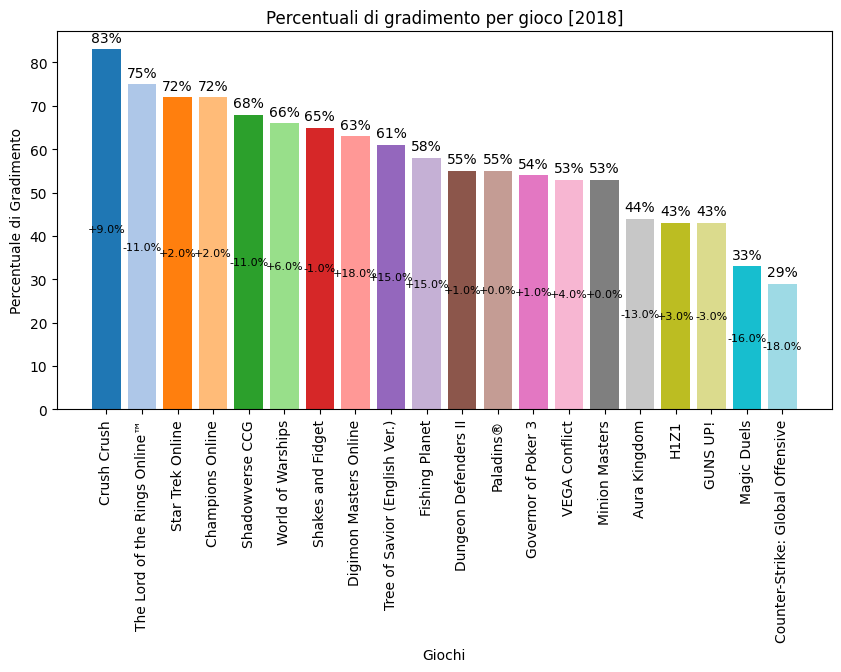

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

colors = plt.cm.tab20(np.linspace(0, 1, len(summary_2018['Name'])))

bars = ax.bar(summary_2018['Name'], summary_2018['Percentuale gradimento'], color=colors)

ax.set_xlabel('Giochi')
ax.set_ylabel('Percentuale di Gradimento')
ax.set_title('Percentuali di gradimento per gioco [2018]')

ax.set_xticklabels(summary_2018['Name'], rotation=90)

for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval:.0f}%', ha='center', va='bottom')

for i, (name, diff) in enumerate(zip(summary_2018['Name'], summary_2018['Differenza gradimento'])):
    if diff != 'NR':
        diff = float(diff)
        ax.text(bars[i].get_x() + bars[i].get_width() / 2, bars[i].get_height() / 2, f'{diff:+.1f}%', fontsize=8, ha='center', va='center', color='black')

plt.subplots_adjust(bottom=0.25)

plt.show()

In [ ]:
summary_genre_2018 = summary_2018.groupby('Genere').agg({'Name': 'size', 'Sentiment 0': 'sum', 'Sentiment 1': 'sum'}).reset_index()

summary_genre_2018.rename(columns={'Name': 'Tot_Giochi'}, inplace=True)

summary_genre_2018['Percentuale gradimento'] = np.ceil(summary_genre_2018['Sentiment 1'] / (summary_genre_2018['Sentiment 0'] + summary_genre_2018['Sentiment 1']) * 100).astype(int)

summary_genre_2018 = summary_genre_2018.sort_values(by='Percentuale gradimento', ascending=False)

summary_genre_2018['Differenza gradimento'] = np.nan

for index, row in summary_genre_2018.iterrows():
    genre = row['Genere']
    if genre in summary_genre_2017['Genere'].values:
        percentuale_2017 = summary_genre_2017.loc[summary_genre_2017['Genere'] == genre, 'Percentuale gradimento'].iloc[0]
        differenza = row['Percentuale gradimento'] - percentuale_2017
        summary_genre_2018.at[index, 'Differenza gradimento'] = differenza
    else:
        summary_genre_2018.at[index, 'Differenza gradimento'] = 'NP'

summary_genre_2018

,Genere,Tot_Giochi,Sentiment 0,Sentiment 1,Percentuale gradimento,Differenza gradimento
4,RP,1,7,34,83,9.0
3,MMORPG,7,82,153,66,6.0
2,MMO,2,83,153,65,6.0
5,S,1,15,20,58,15.0
6,SG,4,85,104,56,-7.0
7,TD,2,83,93,53,0.0
1,FPS,2,116,91,44,-9.0
0,BR,1,77,58,43,3.0


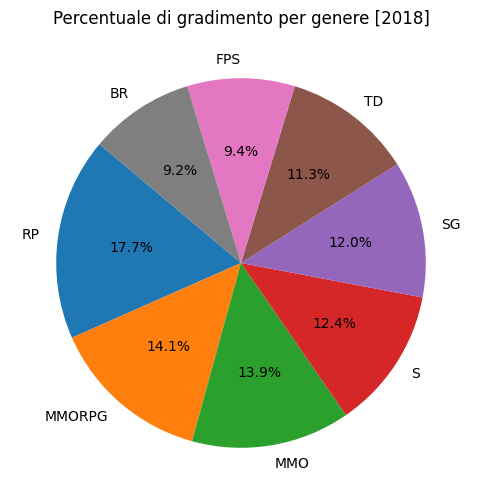

In [ ]:
plt.figure(figsize=(10, 6))
plt.pie(summary_genre_2018['Percentuale gradimento'], labels=summary_genre_2018['Genere'], autopct='%1.1f%%', startangle=140)
plt.title('Percentuale di gradimento per genere [2018]')
plt.show()

SUMMARY FINALE

In [ ]:
summary = data_steam.groupby('name')['sentiment_analysis'].value_counts().unstack(fill_value=0).reset_index()
summary.columns = ['Name', 'Sentiment 0', 'Sentiment 1']

genres = pd.DataFrame({
    'name': ['Aura Kingdom', 'Champions Online', 'Counter-Strike: Global Offensive', 'Crush Crush', 'Digimon Masters Online', 'Dungeon Defenders II', 'Fishing Planet', 'GUNS UP!', 'Governor of Poker 3', 'H1Z1', 'Magic Duels', 'Minion Masters', 'Paladins®', 'Shadowverse CCG', 'Shakes and Fidget', 'Star Trek Online', 'The Lord of the Rings Online™', 'Tree of Savior (English Ver.)', 'VEGA Conflict', 'World of Warships'],
    'genre': ['MMORPG', 'MMORPG', 'FPS', 'RP', 'MMORPG', 'TD', 'S', 'SG', 'MMO', 'BR', 'SG', 'TD', 'FPS', 'SG', 'MMORPG', 'MMORPG', 'MMORPG', 'MMORPG', 'SG', 'MMO']
})

summary['Percentuale gradimento'] = np.ceil(summary['Sentiment 1'] / (summary['Sentiment 0'] + summary['Sentiment 1']) * 100).astype(int)

summary = summary.merge(genres, left_on='Name', right_on='name').drop(columns='name')

summary = summary[['Name', 'genre', 'Sentiment 0', 'Sentiment 1', 'Percentuale gradimento']]

summary = summary.rename(columns={'genre': 'Genere'})

summary = summary.sort_values(by='Percentuale gradimento', ascending=False)

summary

,Name,Genere,Sentiment 0,Sentiment 1,Percentuale gradimento
16,The Lord of the Rings Online™,MMORPG,60,381,87
13,Shadowverse CCG,SG,97,359,79
3,Crush Crush,RP,87,264,76
15,Star Trek Online,MMORPG,162,412,72
1,Champions Online,MMORPG,116,273,71
14,Shakes and Fidget,MMORPG,41,100,71
6,Fishing Planet,S,149,357,71
0,Aura Kingdom,MMORPG,119,207,64
19,World of Warships,MMO,138,230,63
8,Governor of Poker 3,MMO,33,56,63


<ipython-input-129-96353a7b306c>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(summary['Name'], rotation=90)


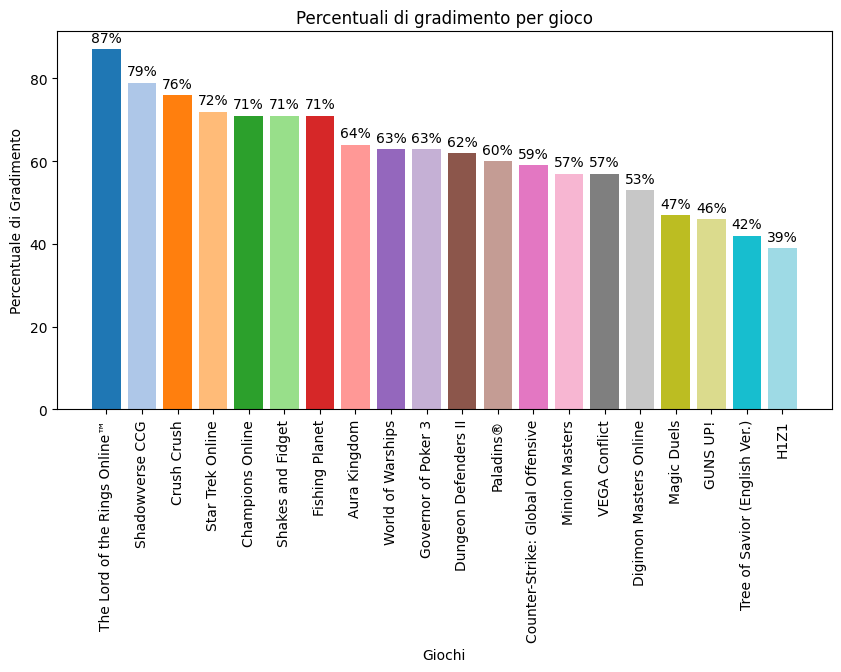

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

colors = plt.cm.tab20(np.linspace(0, 1, len(summary['Name'])))

bars = ax.bar(summary['Name'], summary['Percentuale gradimento'], color=colors)

ax.set_xlabel('Giochi')
ax.set_ylabel('Percentuale di Gradimento')
ax.set_title('Percentuali di gradimento per gioco')

ax.set_xticklabels(summary['Name'], rotation=90)

for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval:.0f}%', ha='center', va='bottom')

plt.subplots_adjust(bottom=0.25)

plt.show()

In [ ]:
summary_genre = summary.groupby('Genere').agg({'Sentiment 0': 'sum', 'Sentiment 1': 'sum'}).reset_index()

summary_genre['Percentuale di gradimento'] = np.ceil(summary_genre['Sentiment 1'] / (summary_genre['Sentiment 0'] + summary_genre['Sentiment 1']) * 100).astype(int)

summary_genre = summary_genre.sort_values(by='Percentuale di gradimento', ascending=False)

summary_genre

,Genere,Sentiment 0,Sentiment 1,Percentuale di gradimento
4,RP,87,264,76
5,S,149,357,71
3,MMORPG,1020,1808,64
2,MMO,171,286,63
7,TD,400,581,60
1,FPS,430,612,59
6,SG,698,909,57
0,BR,281,178,39


<ipython-input-92-85ffcbb35bec>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(summary_genre['Genere'], rotation=45)


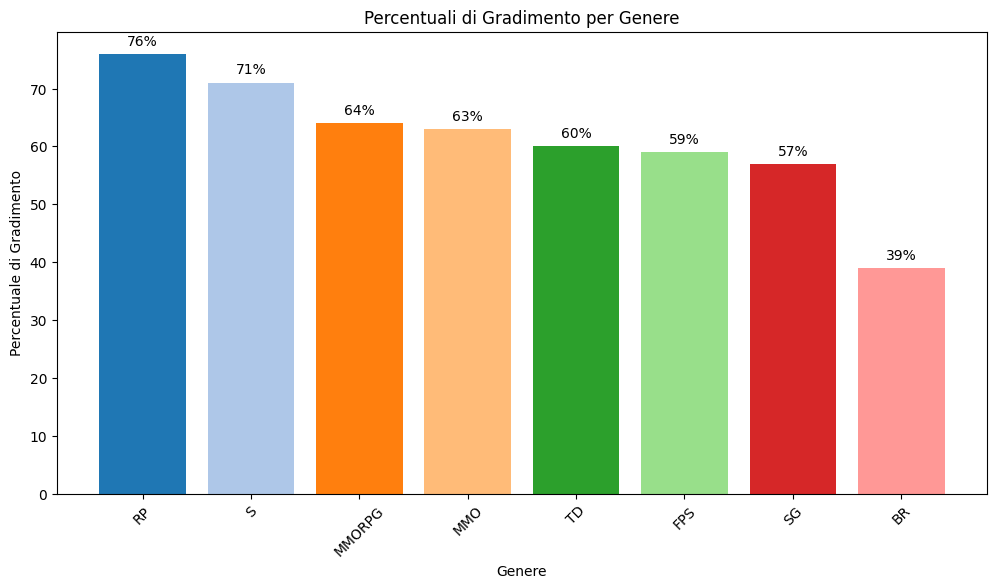

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

colors = plt.cm.tab20(np.linspace(0, 1, len(summary)))

bars = ax.bar(summary_genre['Genere'], summary_genre['Percentuale di gradimento'], color=colors)

ax.set_xlabel('Genere')
ax.set_ylabel('Percentuale di Gradimento')
ax.set_title('Percentuali di Gradimento per Genere')

ax.set_xticklabels(summary_genre['Genere'], rotation=45)

for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.0f}%', ha='center', va='bottom')

plt.show()

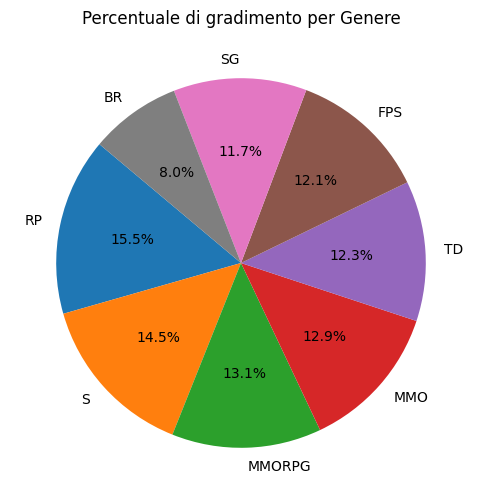

In [ ]:
plt.figure(figsize=(10, 6))
plt.pie(summary_genre['Percentuale di gradimento'], labels=summary_genre['Genere'], autopct='%1.1f%%', startangle=140)
plt.title('Percentuale di gradimento per Genere')
plt.show()

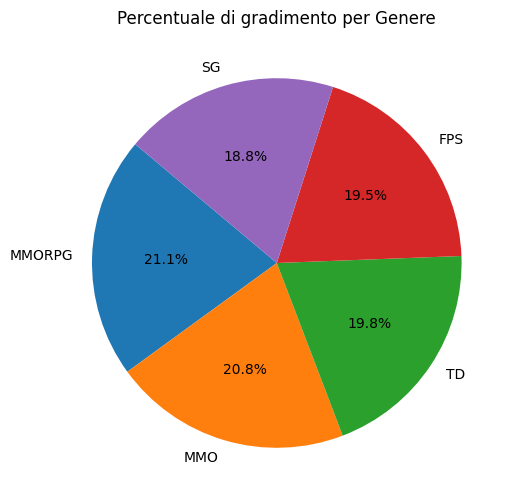

In [ ]:
filtered_genre = summary_genre[~summary_genre['Genere'].isin(['BR', 'S', 'RP'])]

plt.figure(figsize=(10, 6))
plt.pie(filtered_genre['Percentuale di gradimento'], labels=filtered_genre['Genere'], autopct='%1.1f%%', startangle=140)
plt.title('Percentuale di gradimento per Genere')
plt.show()

In [ ]:
summary.to_csv('/content/drive/MyDrive/bert-sa-steam/summary_data_steam.csv')
summary_genre.to_csv('/content/drive/MyDrive/bert-sa-steam/summary_genre_data_steam.csv')